In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
import time
import warnings
warnings.filterwarnings('ignore')

### **MARKET SIMULATOR**

In [3]:
class MarketSimulator:
    
    def __init__(self, initial_price=100.0):
        self.current_price = initial_price
        self.fundamental_value = initial_price
        self.time_step = 0
        
        # Market parameters
        self.volatility = 0.02
        self.mean_reversion_strength = 0.1
        self.liquidity_depth = 1000  # shares per price level
        
        # Order book state
        self.bid_prices = []
        self.ask_prices = []
        self.bid_volumes = []
        self.ask_volumes = []
        
        self._initialize_order_book()
    
    def _initialize_order_book(self):
        mid_price = self.current_price
        spread = 0.02  # 2 cent spread
        
        # Initialize 5 levels on each side
        for i in range(5):
            bid_price = mid_price - spread/2 - i * 0.01
            ask_price = mid_price + spread/2 + i * 0.01
            
            self.bid_prices.append(bid_price)
            self.ask_prices.append(ask_price)
            self.bid_volumes.append(self.liquidity_depth * (1 - i * 0.1))  # Decreasing volume
            self.ask_volumes.append(self.liquidity_depth * (1 - i * 0.1))
    
    def step(self):
        self.time_step += 1
        
        # Update fundamental value (Ornstein-Uhlenbeck process)
        dt = 1.0
        dW = np.random.normal(0, np.sqrt(dt))
        self.fundamental_value += (
            -self.mean_reversion_strength * (self.fundamental_value - 100.0) * dt +
            self.volatility * dW
        )
        
        # Update current price towards fundamental with noise
        price_change = 0.1 * (self.fundamental_value - self.current_price) + np.random.normal(0, 0.01)
        self.current_price += price_change
        
        # Update order book
        self._update_order_book()
        
        # Add some random market activity
        self._add_market_noise()
    
    def _update_order_book(self):
        mid_price = self.current_price
        spread = 0.02 + abs(np.random.normal(0, 0.005))  # Variable spread
        
        # Update prices
        for i in range(len(self.bid_prices)):
            self.bid_prices[i] = mid_price - spread/2 - i * 0.01
            self.ask_prices[i] = mid_price + spread/2 + i * 0.01
            
            # Add some volume dynamics
            volume_noise = np.random.normal(1.0, 0.1)
            self.bid_volumes[i] = max(100, self.liquidity_depth * (1 - i * 0.1) * volume_noise)
            self.ask_volumes[i] = max(100, self.liquidity_depth * (1 - i * 0.1) * volume_noise)
    
    def _add_market_noise(self):
        if np.random.random() < 0.1:  # 10% chance of market order
            # Random market order consumes some liquidity
            side = np.random.choice(['bid', 'ask'])
            quantity = np.random.randint(50, 200)
            
            if side == 'bid' and self.ask_volumes:
                self.ask_volumes[0] = max(50, self.ask_volumes[0] - quantity)
            elif side == 'ask' and self.bid_volumes:
                self.bid_volumes[0] = max(50, self.bid_volumes[0] - quantity)
    
    def execute_trade(self, quantity: int, side: str = 'buy') -> tuple:
        if quantity <= 0:
            return self.current_price, 0
        
        total_cost = 0
        remaining_quantity = quantity
        depth_consumed = 0
        levels_hit = 0
        
        if side == 'buy':
            # Execute against ask side
            for i, (price, volume) in enumerate(zip(self.ask_prices, self.ask_volumes)):
                if remaining_quantity <= 0:
                    break
                
                trade_quantity = min(remaining_quantity, volume)
                total_cost += price * trade_quantity
                remaining_quantity -= trade_quantity
                levels_hit += 1
                
                # Market impact: reduce available volume
                self.ask_volumes[i] = max(0, self.ask_volumes[i] - trade_quantity)
                
                # If we consumed significant portion of level, count as depth consumed
                if trade_quantity / volume > 0.5:
                    depth_consumed += 1
        
        else:  # sell
            # Execute against bid side
            for i, (price, volume) in enumerate(zip(self.bid_prices, self.bid_volumes)):
                if remaining_quantity <= 0:
                    break
                
                trade_quantity = min(remaining_quantity, volume)
                total_cost += price * trade_quantity
                remaining_quantity -= trade_quantity
                levels_hit += 1
                
                # Market impact: reduce available volume
                self.bid_volumes[i] = max(0, self.bid_volumes[i] - trade_quantity)
                
                if trade_quantity / volume > 0.5:
                    depth_consumed += 1
        
        # Calculate average execution price
        executed_quantity = quantity - remaining_quantity
        avg_execution_price = total_cost / executed_quantity if executed_quantity > 0 else self.current_price
        
        # Market impact on price (temporary)
        impact_factor = min(0.001 * quantity / 1000, 0.01)  # Max 1% impact
        if side == 'buy':
            self.current_price += impact_factor
        else:
            self.current_price -= impact_factor
        
        return avg_execution_price, depth_consumed
    
    def get_market_features(self) -> dict:
        best_bid = self.bid_prices[0] if self.bid_prices else self.current_price - 0.01
        best_ask = self.ask_prices[0] if self.ask_prices else self.current_price + 0.01
        
        # Calculate volume imbalance for multiple levels
        volume_imbalances = []
        for level in range(1, 6):  # 5 levels
            bid_vol = sum(self.bid_volumes[:level]) if len(self.bid_volumes) >= level else 0
            ask_vol = sum(self.ask_volumes[:level]) if len(self.ask_volumes) >= level else 0
            total_vol = bid_vol + ask_vol
            imbalance = bid_vol / total_vol if total_vol > 0 else 0.5
            volume_imbalances.append(imbalance)
        
        return {
            'mid_price': (best_bid + best_ask) / 2,
            'spread': best_ask - best_bid,
            'best_bid': best_bid,
            'best_ask': best_ask,
            'volume_imbalances': volume_imbalances,
            'total_bid_volume': sum(self.bid_volumes),
            'total_ask_volume': sum(self.ask_volumes)
        }

### **ENVIRONMENT CREATION**

In [5]:
class OptimalExecEnv(gym.Env):
    def __init__(self, total_shares=20000, total_time_steps=1800, q_min=20):
        super(OptimalExecEnv, self).__init__()
        
        # Environment parameters (from paper)
        self.total_shares = total_shares
        self.total_time_steps = total_time_steps
        self.q_min = q_min
        self.alpha = 2.0  # Depth penalty coefficient (was missing!)
        self.end_of_time_penalty = 5.0  # Penalty per unexecuted share (was missing!)
        
        # Action space: 5 discrete actions [0, 1, 2, 3, 4]
        self.action_space = spaces.Discrete(5)
        
        # Observation space: [% holdings, % time, 5x volume_imbalance, best_bid, best_ask, spread, market_features]
        # Total: 12 features
        self.observation_space = spaces.Box(
            low=np.array([0.0] * 12, dtype=np.float32),
            high=np.array([1.0] * 7 + [200.0] * 5, dtype=np.float32),  # Prices can be > 1
            dtype=np.float32
        )
        
        # Initialize market simulator (was missing!)
        self.market_simulator = MarketSimulator()
        
        # State variables
        self.current_step = 0
        self.shares_remaining = 0
        self.arrival_price = 0.0
        self.total_executed_value = 0.0
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        # Reset internal state
        self.current_step = 0
        self.shares_remaining = self.total_shares
        self.total_executed_value = 0.0
        
        # Reset market simulator
        self.market_simulator = MarketSimulator()
        self.arrival_price = self._get_market_price()  # Now implemented!
        
        # Return initial observation
        obs = self._get_obs()  # Now implemented!
        return obs, {}
    
    def step(self, action):
        # 1. Determine quantity to trade (was missing!)
        quantity_to_trade = self._get_quantity_from_action(action)
        
        # 2. Execute trade using market simulator (now implemented!)
        execution_price, depth_consumed = self.market_simulator.execute_trade(
            quantity_to_trade, side='buy'
        )
        
        # 3. Calculate reward using the paper's formula
        if quantity_to_trade > 0:
            implementation_shortfall = quantity_to_trade * (self.arrival_price - execution_price)
            impact_penalty = self.alpha * depth_consumed
            reward = implementation_shortfall - impact_penalty
            
            # Update state
            self.shares_remaining -= quantity_to_trade
            self.total_executed_value += execution_price * quantity_to_trade
        else:
            reward = 0
        
        # 4. Advance time
        self.current_step += 1
        self.market_simulator.step()
        
        # 5. Check termination
        terminated = (self.shares_remaining <= 0) or (self.current_step >= self.total_time_steps)
        
        # 6. Apply end-of-period penalty
        if terminated and self.shares_remaining > 0:
            reward -= self.end_of_time_penalty * self.shares_remaining
        
        # 7. Get next observation
        obs = self._get_obs()
        
        # 8. Prepare info dict
        info = {
            'shares_remaining': self.shares_remaining,
            'execution_progress': 1.0 - (self.shares_remaining / self.total_shares),
            'time_progress': self.current_step / self.total_time_steps,
            'avg_execution_price': (self.total_executed_value / 
                                  (self.total_shares - self.shares_remaining)) 
                                  if self.shares_remaining < self.total_shares else self.arrival_price
        }
        
        return obs, reward, terminated, False, info
    
    def _get_obs(self) -> np.ndarray:
        # Get market features from simulator
        market_features = self.market_simulator.get_market_features()
        
        # Calculate state components
        holdings_pct = self.shares_remaining / self.total_shares
        time_pct = self.current_step / self.total_time_steps
        
        # Volume imbalances (5 levels)
        volume_imbalances = market_features['volume_imbalances']
        
        # Price features (normalized)
        best_bid_norm = market_features['best_bid'] / 100.0
        best_ask_norm = market_features['best_ask'] / 100.0
        spread_norm = market_features['spread'] / 1.0  # Normalize by typical spread
        mid_price_norm = market_features['mid_price'] / 100.0
        
        # Additional market features
        total_liquidity = (market_features['total_bid_volume'] + 
                          market_features['total_ask_volume']) / 10000.0  # Normalize
        
        # Combine all features (total: 12 features)
        obs = np.array([
            holdings_pct,           # 1
            time_pct,              # 2
            *volume_imbalances,    # 3-7 (5 levels)
            best_bid_norm,         # 8
            best_ask_norm,         # 9
            spread_norm,           # 10
            mid_price_norm,        # 11
            total_liquidity        # 12
        ], dtype=np.float32)
        
        return obs
    
    def _get_quantity_from_action(self, action: int) -> int:
        if action == 0:
            return 0
        else:
            quantity = action * self.q_min
            return min(quantity, self.shares_remaining)  # Don't exceed remaining shares
    
    def _get_market_price(self) -> float:
        market_features = self.market_simulator.get_market_features()
        return market_features['mid_price']

### **BASELINE STRATEGIES**

In [7]:
def evaluate_twap_policy(env: OptimalExecEnv) -> float:
    obs, _ = env.reset()
    total_reward = 0
    
    # Calculate TWAP rate
    shares_per_step = env.total_shares / env.total_time_steps
    
    while True:
        # Determine TWAP action
        if shares_per_step >= env.q_min:
            action = min(4, int(shares_per_step / env.q_min))
        else:
            action = 1 if env.shares_remaining > 0 else 0
        
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        
        if terminated or truncated:
            break
    
    return total_reward

def evaluate_aggressive_policy(env: OptimalExecEnv) -> float:
    obs, _ = env.reset()
    total_reward = 0
    
    while True:
        action = 2  # Always execute 2*q_min
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        
        if terminated or truncated:
            break
    
    return total_reward

def evaluate_passive_policy(env: OptimalExecEnv) -> float:
    obs, _ = env.reset()
    total_reward = 0
    
    while True:
        if np.random.random() < 0.6:
            action = 0  # Do nothing
        else:
            action = np.random.randint(1, 5)  # Random execution
        
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        
        if terminated or truncated:
            break
    
    return total_reward

### **TRAINING SCRIPT**

In [9]:
def main():
    print("🏗️  Setting up environment...")
    
    # Create environment
    env = OptimalExecEnv()
    
    # Check environment (important for debugging!)
    print("✅ Checking environment validity...")
    try:
        check_env(env)
        print("✅ Environment check passed!")
    except Exception as e:
        print(f"❌ Environment check failed: {e}")
        return
    
    # Wrap environment with Monitor for logging
    env = Monitor(env)
    
    print("🧠 Initializing DQN model...")
    
    # Create DQN model with paper's hyperparameters
    model = DQN(
        'MlpPolicy',
        env,
        learning_rate=1e-3,
        buffer_size=100000,
        learning_starts=1000,
        batch_size=32,
        gamma=0.9999,
        exploration_fraction=0.1,
        exploration_initial_eps=1.0,
        exploration_final_eps=0.02,
        train_freq=1,
        gradient_steps=1,
        target_update_interval=1000,
        verbose=1,
        device='cpu'  # Use 'cuda' if GPU available
    )
    
    print("🚀 Starting training...")
    start_time = time.time()
    
    # Train the model
    model.learn(total_timesteps=50000, log_interval=10)
    
    training_time = time.time() - start_time
    print(f"✅ Training completed in {training_time:.1f} seconds")
    
    # Save the model
    model.save("dqn_optimal_execution_complete")
    print("💾 Model saved!")
    
    return model, env

def evaluate_all_strategies(model, env, num_episodes=50):
    print(f"\n📊 Evaluating all strategies over {num_episodes} episodes...")
    
    results = {
        'DQN': [],
        'TWAP': [],
        'Aggressive': [],
        'Passive': []
    }
    
    completion_rates = {strategy: [] for strategy in results.keys()}
    
    for episode in range(num_episodes):
        if episode % 10 == 0:
            print(f"   Episode {episode + 1}/{num_episodes}")
        
        # Evaluate DQN
        obs, _ = env.reset()
        episode_reward = 0
        while True:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            if terminated or truncated:
                break
        
        results['DQN'].append(episode_reward)
        completion_rates['DQN'].append(info['execution_progress'] >= 0.99)
        
        # Evaluate baselines
        strategies = [
            ('TWAP', evaluate_twap_policy),
            ('Aggressive', evaluate_aggressive_policy),
            ('Passive', evaluate_passive_policy)
        ]
        
        for strategy_name, strategy_func in strategies:
            test_env = OptimalExecEnv()  # Fresh environment
            reward = strategy_func(test_env)
            results[strategy_name].append(reward)
            completion_rates[strategy_name].append(test_env.shares_remaining == 0)
    
    return results, completion_rates

def create_performance_plots(results, completion_rates):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Reward distributions
    ax1 = axes[0, 0]
    for strategy, rewards in results.items():
        ax1.hist(rewards, alpha=0.6, label=strategy, bins=15)
    ax1.set_xlabel('Total Reward')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Reward Distribution by Strategy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Box plot comparison
    ax2 = axes[0, 1]
    data_to_plot = [results[strategy] for strategy in results.keys()]
    bp = ax2.boxplot(data_to_plot, labels=results.keys(), patch_artist=True)
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    ax2.set_ylabel('Total Reward')
    ax2.set_title('Performance Comparison')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # 3. Performance statistics
    ax3 = axes[1, 0]
    strategies = list(results.keys())
    means = [np.mean(results[s]) for s in strategies]
    stds = [np.std(results[s]) for s in strategies]
    
    x = range(len(strategies))
    bars = ax3.bar(x, means, yerr=stds, capsize=5, alpha=0.7, color=colors)
    ax3.set_xticks(x)
    ax3.set_xticklabels(strategies, rotation=45)
    ax3.set_ylabel('Mean Reward ± Std')
    ax3.set_title('Performance Statistics')
    ax3.grid(True, alpha=0.3)
    
    # 4. Completion rates
    ax4 = axes[1, 1]
    completion_means = [np.mean(completion_rates[s]) * 100 for s in strategies]
    bars = ax4.bar(strategies, completion_means, alpha=0.7, color=colors)
    ax4.set_ylabel('Completion Rate (%)')
    ax4.set_title('Execution Completion Rate')
    ax4.set_ylim(0, 105)
    ax4.grid(True, alpha=0.3)
    
    # Add percentage labels
    for bar, pct in zip(bars, completion_means):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{pct:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def print_performance_summary(results, completion_rates):
    print("\n📈 PERFORMANCE SUMMARY")
    print("=" * 50)
    
    df_data = []
    for strategy in results.keys():
        df_data.append({
            'Strategy': strategy,
            'Mean_Reward': np.mean(results[strategy]),
            'Std_Reward': np.std(results[strategy]),
            'Completion_Rate': np.mean(completion_rates[strategy]) * 100,
            'Min_Reward': np.min(results[strategy]),
            'Max_Reward': np.max(results[strategy])
        })
    
    df = pd.DataFrame(df_data).sort_values('Mean_Reward', ascending=False)
    print(df.to_string(index=False, float_format='%.2f'))
    
    # Calculate improvements
    dqn_reward = df[df['Strategy'] == 'DQN']['Mean_Reward'].iloc[0]
    twap_reward = df[df['Strategy'] == 'TWAP']['Mean_Reward'].iloc[0]
    improvement = ((dqn_reward - twap_reward) / abs(twap_reward)) * 100
    
    print(f"\n KEY FINDINGS:")
    print(f"   • DQN vs TWAP improvement: {improvement:+.1f}%")
    print(f"   • Best strategy: {df.iloc[0]['Strategy']}")
    print(f"   • Highest completion rate: {df['Completion_Rate'].max():.1f}%")

🏗️  Setting up environment...
✅ Checking environment validity...
✅ Environment check passed!
🧠 Initializing DQN model...
Using cpu device
Wrapping the env in a DummyVecEnv.
🚀 Starting training...
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 1.33e+03  |
|    ep_rew_mean      | -4.33e+04 |
|    exploration_rate | 0.02      |
| time/               |           |
|    episodes         | 10        |
|    fps              | 345       |
|    time_elapsed     | 38        |
|    total_timesteps  | 13278     |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 0.0955    |
|    n_updates        | 12277     |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 1.56e+03  |
|    ep_rew_mean      | -4.45e+04 |
|    exploration_rate | 0.02      |
| time/               |           |
|    episodes         | 20        |
|    fps    

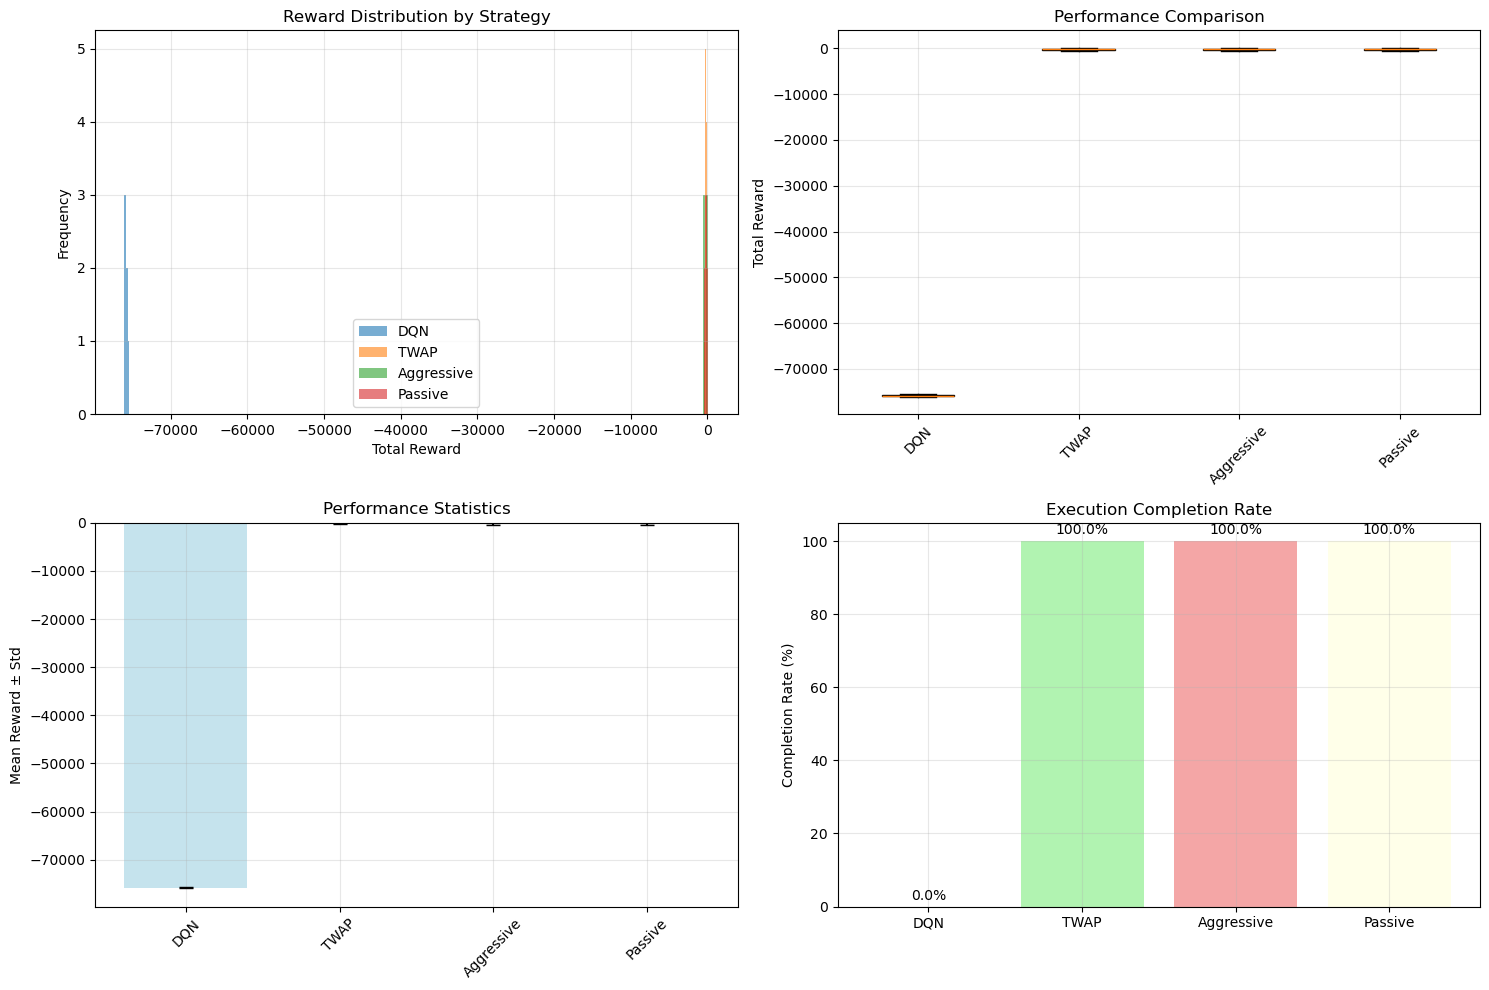


📈 PERFORMANCE SUMMARY
  Strategy  Mean_Reward  Std_Reward  Completion_Rate  Min_Reward  Max_Reward
      TWAP      -197.07      138.03           100.00     -511.03      100.61
Aggressive      -234.83      194.61           100.00     -546.17      115.85
   Passive      -235.54      134.51           100.00     -486.11       32.19
       DQN    -75817.12      131.57             0.00   -76043.72   -75497.45

 KEY FINDINGS:
   • DQN vs TWAP improvement: -38371.8%
   • Best strategy: TWAP
   • Highest completion rate: 100.0%

 IMPLEMENTATION FINISHED!
 _get_obs() method
 _get_quantity_from_action() method
 _get_market_price() method
 Complete MarketSimulator class
 execute_trade() method
 TWAP evaluation function
 All missing parameters (alpha, penalties)
 Complete training and evaluation pipeline


In [10]:
if __name__ == "__main__":
    print("=" * 60)
    
    # Train model
    model, env = main()
    
    # Evaluate all strategies
    results, completion_rates = evaluate_all_strategies(model, env, num_episodes=30)
    
    # Create visualizations
    create_performance_plots(results, completion_rates)
    
    # Print summary
    print_performance_summary(results, completion_rates)
    
    print("\n IMPLEMENTATION FINISHED!")
    print(" _get_obs() method")
    print(" _get_quantity_from_action() method") 
    print(" _get_market_price() method")
    print(" Complete MarketSimulator class")
    print(" execute_trade() method")
    print(" TWAP evaluation function")
    print(" All missing parameters (alpha, penalties)")
    print(" Complete training and evaluation pipeline")